# Letter Recognition Using SVM



## Data Understanding 

Let's first understand the shape, attributes etc. of the MNIST dataset.

In [3]:
# libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

# dataset
numbers = pd.read_csv("train.csv")
#letters_test = pd.read_csv("test.csv")

In [4]:
numbers.shape

(42000, 785)

In [5]:
numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [6]:
numbers.head()

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

In [7]:
order = list(np.sort(numbers['label'].unique()))
print(order)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


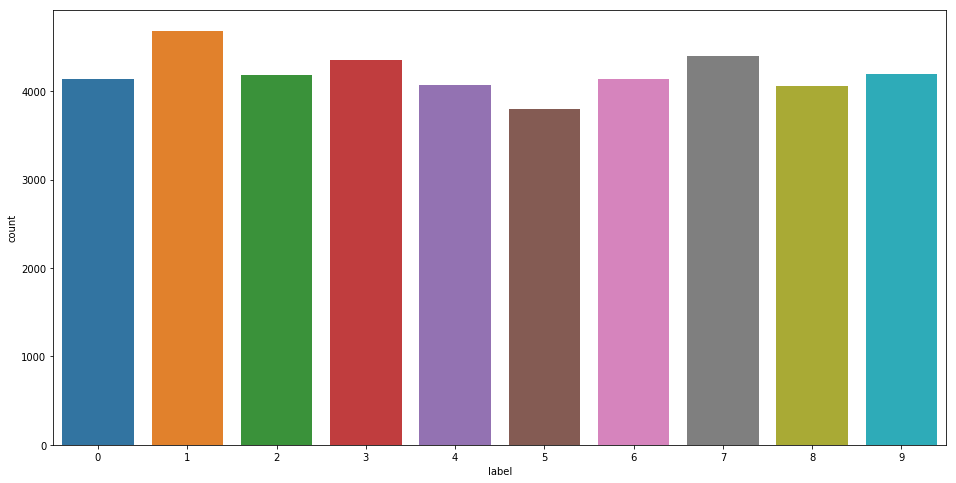

In [8]:
# basic plots: What is the distribution of letters in the dataset

plt.figure(figsize=(16, 8))
sns.countplot(x='label', 
            data=numbers, 
            order=order)

In [9]:
number_means = numbers.groupby('label').mean()
number_means

pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
label                                                                           
0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
8         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
9         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  \
label          ...                                                     
0         0.0  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
1         0.0  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
2         0.0  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
3         0.0  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
4         0.0  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
5         0.0  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
6         0.0  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
7         0.0  ...  1.846626  0.939105  0.397182  0.086344  0.118155   
8         0.0  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
9         0.0  ...  0.258596  0.187440  0.174546  0.111748  0.048711   

       pixel779  pixel780  pixel781  pixel782  pixel783  
label                                                    
0      0.000000       0.0       0.0       0.0       0.0  
1      0.000000       0.0       0.0       0.0       0.0  
2      0.000000       0.0       0.0       0.0       0.0  
3      0.000000       0.0       0.0       0.0       0.0  
4      0.000000       0.0       0.0       0.0       0.0  
5      0.000000       0.0       0.0       0.0       0.0  
6      0.000000       0.0       0.0       0.0       0.0  
7      0.027267       0.0       0.0       0.0       0.0  
8      0.000000       0.0       0.0       0.0       0.0  
9      0.000000       0.0       0.0       0.0       0.0  

[10 rows x 784 columns]

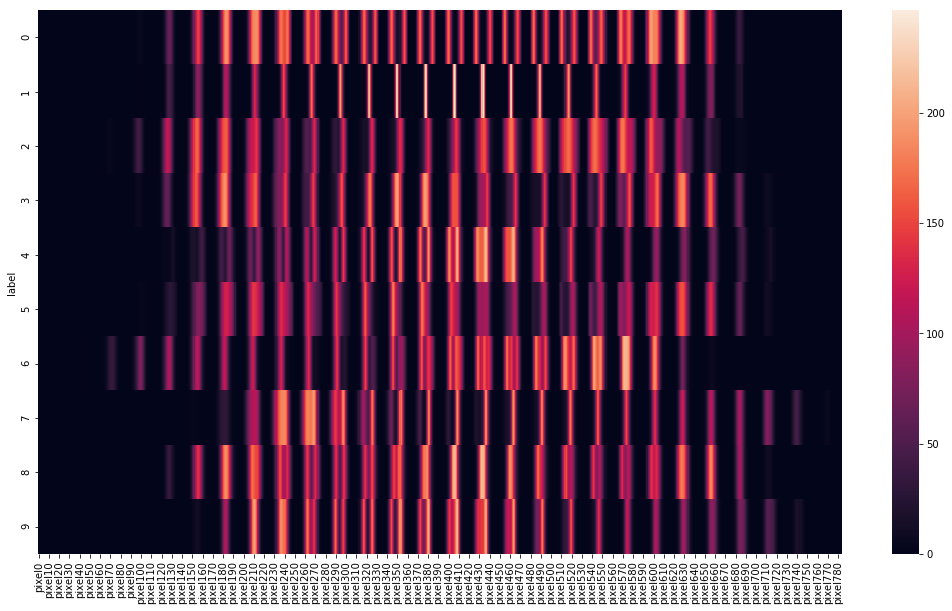

In [10]:
plt.figure(figsize=(18, 10))
sns.heatmap(number_means)

## Data Preparation

Let's conduct some data preparation steps before modeling. Firstly, let's see if it is important to **rescale** the features, since they may have varying ranges. For example, here are the average values:

# average feature values
round(numbers.drop('label', axis=1).mean(), 2)

In this case, the average values do not vary a lot (e.g. having a diff of an order of magnitude). Nevertheless, it is better to rescale them.

In [11]:
# splitting into X and y
X = numbers.drop("label", axis = 1)
y = numbers['label']

In [12]:
# scaling the features
X_scaled = scale(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.8, random_state = 10)


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


## Model Building

Let's fist build two basic models - linear and non-linear with default hyperparameters, and compare the accuracies.

In [13]:
# linear model

model_linear = SVC(kernel='linear')
model_linear.fit(X_train, y_train)

# predict
y_pred = model_linear.predict(X_test)

In [14]:
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# cm
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.9062797619047619 

[[3228    1    7    6    8   16   33    3    5    2]
 [   0 3641   17   14    5    4    4    5   16   10]
 [  37   53 3013   56   57   13   37   25   39    5]
 [  22   22  103 3069   11  155    6   21   67   34]
 [  12   12   32    7 2994    8   16   22    7  144]
 [  48   25   29  130   38 2683   38    5   49   21]
 [  35    9   66    2   31   33 3077    1   10    0]
 [  14   26   74   22   83   16    2 3173    5  121]
 [  37   88   57  112   25  108   31   18 2760   34]
 [  11    9   29   47  190   28    1  186   26 2813]]


The linear model gives approx. 91% accuracy. Let's look at a sufficiently non-linear model with randomly chosen hyperparameters.

In [15]:
# non-linear model
# using poly kernel, C=1, default value of gamma

# model
non_linear_model = SVC(kernel='poly')

# fit
non_linear_model.fit(X_train, y_train)

# predict
y_pred = non_linear_model.predict(X_test)

C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [16]:
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# cm
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.8683630952380952 

[[2924    0    8    4  164   10   32    0  163    4]
 [   0 3636    8    1   26    0    6    0   36    3]
 [   6   23 2575   37  305    1    8   12  360    8]
 [   1   16   30 2975  120   16    6    9  284   53]
 [   2   10   24    2 3096    0    3    4    9  104]
 [   4    1    9  101  244 2270   28    1  341   67]
 [   8   12   16    2  191   25 2910    0  100    0]
 [   4   47    9   11  245    0    0 2754   22  444]
 [   4   18   20   34   82   31    2    4 3034   41]
 [   3   10    4   27  200    4    0   40   49 3003]]


In [17]:
# non-linear model
# using poly kernel, C=1, default value of gamma

# model
non_linear_model = SVC(kernel='poly',C=2)

# fit
non_linear_model.fit(X_train, y_train)

# predict
y_pred = non_linear_model.predict(X_test)

C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [18]:
numbers['pixel0'].astype('category').value_counts()

0    42000
Name: pixel0, dtype: int64

In [19]:
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# cm
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.9088392857142857 

[[3069    0    9    4   61   15   25    0  123    3]
 [   0 3639    9    2   16    0    7    0   40    3]
 [  10   16 2802   37  155    1    8   24  276    6]
 [   2   10   32 3138   48   31    4   16  194   35]
 [   3    8   18    2 3127    0    4    5   10   77]
 [   8    0    9   79  101 2610   27    2  190   40]
 [  13    4   15    1   90   32 3030    0   79    0]
 [   5   28   10   12  166    0    0 3035   33  247]
 [   6   16   22   29   49   37    2    3 3071   35]
 [   3    7    8   30  173    5    0   45   53 3016]]


As we can see that the increase in the value of 'C' is improving the accuracy. That means making the model complex is helping. Let's using GridSearchCV() for finding the optimal value of 'C'

## Grid Search: Hyperparameter Tuning for Polynomial kernel

Let's now tune the model to find the optimal values of C and gamma corresponding to an Polynomial kernel. We'll use 5-fold cross validation.

In [20]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 10)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]


# specify model
model_poly = SVC(kernel="poly")

# set up GridSearchCV()
model_cv_poly = GridSearchCV(estimator = model_poly, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,n_jobs=-1)      

# fit the model
model_cv_poly.fit(X_train, y_train)                  


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
exception calling callback for <Future at 0x1f100171d68 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\sklearn\externals\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Anaconda\lib\site-packages\sklearn\externals\joblib\parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "C:\Anaconda\lib\site-packages\sklearn\externals\joblib\parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "C:\Anaconda\lib\site-packages\sklearn\externals\joblib\parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Anaconda\lib\site-packages\sklearn\externals\joblib\parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Anaconda\lib\site-packages\sklearn\externals\job

KeyboardInterrupt: 

In [ ]:
# cv results
cv_results_poly = pd.DataFrame(model_cv_poly.cv_results_)
cv_results_poly

In [ ]:
# converting C to numeric type for plotting on x-axis
cv_results_poly['param_C'] = cv_results_poly['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results_poly[cv_results_poly['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1.2])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results_poly[cv_results_poly['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1.2])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results_poly[cv_results_poly['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


From the above figures, we can get some useful insights-

- As the value of gamma is increasing, the model accuracy is increasing. That means the model performs better with increase in non-linearity.
- The model tends to slightly overfit in case of gamma=0.001 with the increase in 'C'. 
- With gamma=0.01, the value of 'C' has no affect on the accuracy and the train accuracy is 100% which means the model has memorized the entire dataset.

Let's now choose the best hyperparameters with 'polynomial' kernel

In [ ]:
# printing the optimal accuracy score and hyperparameters using polynomial kernel
best_score = model_cv_poly.best_score_
best_hyperparams = model_cv_poly.best_params_

print("The best test score is {0} corresponding to hyperparameters {1} using polynomial kernel".format(best_score, best_hyperparams))

## Grid Search: Hyperparameter Tuning for RBF kernel

Let's now tune the model to find the optimal values of C and gamma corresponding to an RBF kernel. We'll use 5-fold cross validation.

In [ ]:
# specify model
model_rbf = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv_rbf = GridSearchCV(estimator = model_rbf, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,n_jobs=-1)      

# fit the model
model_cv_rbf.fit(X_train, y_train)                  


In [ ]:
# cv results
cv_results_rbf = pd.DataFrame(model_cv_rbf.cv_results_)
cv_results_rbf

In [ ]:
# converting C to numeric type for plotting on x-axis
cv_results_rbf['param_C'] = cv_results_rbf['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results_rbf[cv_results_rbf['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.6, 1.2])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results_rbf[cv_results_rbf['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1.2])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results_rbf[cv_results_rbf['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1.2])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


From the above figures, we can get some useful insights-

- As the value of gamma is increasing, the model accuracy is increasing. That means the model performs better with increase in non-linearity.
- The model tends to slightly overfit in case of gamma=0.001 with the increase in 'C'. 
- With gamma=0.01, the value of 'C' has no affect on the accuracy and the train and test accuracy are exactly equal

Let's now choose the best hyperparameters with 'polynomial' kernel

In [ ]:
# printing the optimal accuracy score and hyperparameters using rbf kernel
best_score = model_cv_rbf.best_score_
best_hyperparams = model_cv_rbf.best_params_

print("The best test score is {0} corresponding to hyperparameters {1} using rbf kernel".format(best_score, best_hyperparams))

Trying models with different hyper parameters. rbf kernel with gamma=0.005 and C values 1, 10, 100, 1000

In [ ]:
# specify model
model_rbf_1 = SVC(kernel="rbf", gamma=0.005)

hyper_params_1 = [{'C': [1, 10, 100, 1000]}]

# set up GridSearchCV()
model_cv_rbf_1 = GridSearchCV(estimator = model_rbf_1, 
                        param_grid = hyper_params_1, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv_rbf_1.fit(X_train, y_train) 

In [ ]:
# cv results
cv_results_rbf_1 = pd.DataFrame(model_cv_rbf_1.cv_results_)
cv_results_rbf_1

In [ ]:
plt.plot(cv_results_rbf_1["param_C"], cv_results_rbf_1["mean_test_score"])
plt.plot(cv_results_rbf_1["param_C"], cv_results_rbf_1["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.005")
plt.ylim([0.60, 1.2])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


In [ ]:
# specify model
model_rbf_2 = SVC(kernel="rbf")

hyper_params_2 = [ {'gamma': [0.0003,0.0005,0.0008],
                     'C': [1, 10, 100, 1000]}]

# set up GridSearchCV()
model_cv_rbf_2 = GridSearchCV(estimator = model_rbf_2, 
                        param_grid = hyper_params_2, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv_rbf_2.fit(X_train, y_train) 

In [ ]:
# cv results
cv_results_rbf_2 = pd.DataFrame(model_cv_rbf_2.cv_results_)
cv_results_rbf_2

In [ ]:
# converting C to numeric type for plotting on x-axis
cv_results_rbf_2['param_C'] = cv_results_rbf_2['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results_rbf_2[cv_results_rbf_2['param_gamma']==0.0003]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0003")
plt.ylim([0.6, 1.2])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results_rbf_2[cv_results_rbf_2['param_gamma']==0.0005]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0005")
plt.ylim([0.60, 1.2])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results_rbf_2[cv_results_rbf_2['param_gamma']==0.0008]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0008")
plt.ylim([0.6, 1.2])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


In [ ]:
# printing the optimal accuracy score and hyperparameters using rbf kernel
best_score = model_cv_rbf_2.best_score_
best_hyperparams = model_cv_rbf_2.best_params_

print("The best test score is {0} corresponding to hyperparameters {1} using rbf kernel".format(best_score, best_hyperparams))

#### The best test score is 0.9485714285714286 corresponding to hyperparameters {'C': 1, 'gamma': 0.01} using polynomial kernel

Let's build the final model with the above hyper parameters

In [ ]:
# model with optimal hyperparameters

# model
model_poly_final = SVC(C=1, gamma=0.01, kernel="poly")

model_poly_final.fit(X_train, y_train)
y_pred = model_poly_final.predict(X_test)

# metrics
print("accuracy", metrics.accuracy_score(y_test, y_pred), "\n")
matrix = metrics.confusion_matrix(y_test, y_pred)

### The final model is built with polynomial kernel with hyper parameters of C=1 and gamma=0.01. We got a test accuracy of 95.66%

#### Calculating classwise accuracy

In [ ]:
matrix.diagonal()/matrix.sum(axis=1)